In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pywt
from scipy import stats

In [2]:
def autocorr(X, max_d):
    ac = np.zeros(max_d)
    D = np.arange(max_d)
    ac[0] = 1.0
    for d in D[1:]:
        X1 = X[:-d]
        X2 = X[d:]
        ac[d] = np.nanmean(X1 * X2) - np.nanmean(X1)*np.nanmean(X2)
        ac[d] /= np.nanstd(X1)*np.nanstd(X2)
    return D, ac

def autocov(X, max_d):
    ac = np.zeros(max_d)
    D = np.arange(max_d)
    ac[0] = np.var(X)
    for d in D[1:]:
        X1 = X[:-d]
        X2 = X[d:]
        ac[d] = np.nanmean(X1 * X2) - np.nanmean(X1)*np.nanmean(X2)
    return D, ac

def anscombe_transform(X):
    return 2.0*np.sqrt(X)
def anscombe_transform_inverse(X):
    return (X/2.0)**2

def denoise_wavelets(wavelet_coeffs, t=1.0):
    return [wavelet_coeffs[0]] + [np.sign(wc)*np.maximum(0, np.abs(wc) - t) for wc in wavelet_coeffs[1:]]

In [3]:
def denoise(X, wavelet='db1', extension_mode='constant', t=1.0, anscombe=True):
    if anscombe:
        X = anscombe_transform(X)
    wc = pywt.wavedec(X, wavelet, extension_mode)
    wc_denoised = denoise_wavelets(wc, t=t)
    inv = pywt.waverec(wc_denoised, wavelet, extension_mode)
    if len(inv) > len(X):
        inv = inv[:-(len(inv)-len(X))]
    if anscombe:
        inv = anscombe_transform_inverse(inv)
    return inv

In [4]:
recomb_dir = "../data/recombination_maps/Comeron_tables/"
w_start_r, recomb = np.loadtxt(recomb_dir + 'Comeron_100kb_chr2L.txt', unpack=True)

In [25]:
div_fn = "../sandbox/old_diversity/Chr2L.all.N0.diversity.100000.txt.gz"
w_start_d, n_sites, n_poly, pi, avg_maf = np.loadtxt(div_fn,
                                           skiprows=1, usecols=np.arange(5), unpack=True)

In [6]:
print(w_start_r.shape, w_start_d.shape)

(231,) (214,)


In [7]:
print([int(w) for w in w_start_r[:10]])
print([int(w) for w in w_start_d[:10]])

[1, 100001, 200001, 300001, 400001, 500001, 600001, 700001, 800001, 900001]
[100001, 200001, 300001, 400001, 500001, 600001, 700001, 800001, 900001, 1000001]


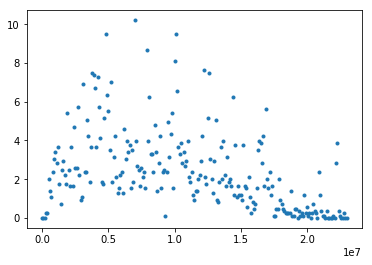

In [8]:
plt.plot(w_start_r, recomb,'.')
plt.show()

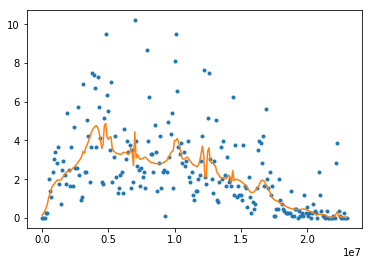

In [9]:
wavelet = 'db4'
threshold = 4.5

min_r = min(recomb[recomb>0])
recomb_norm = np.round(recomb / min_r)
r_denoised = denoise(recomb_norm, t=threshold, wavelet=wavelet)*min_r

plt.plot(w_start_r, recomb, '.')
plt.plot(w_start_r, r_denoised, '-')
plt.show()

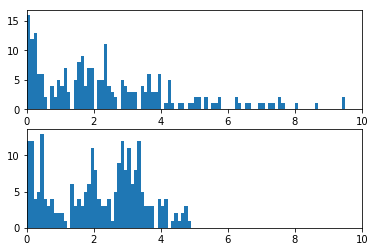

In [10]:
xlim = [0,10]
bins = np.arange(0,10,0.1)

ax = plt.subplot(211)
ax.hist(recomb, bins=bins)
ax.set_xlim(xlim)

ax = plt.subplot(212)
ax.hist(r_denoised, bins=bins)
ax.set_xlim(xlim)
plt.show()

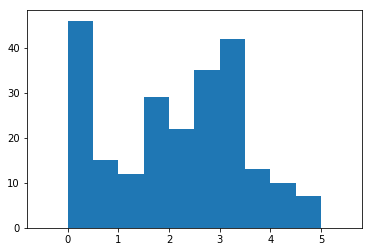

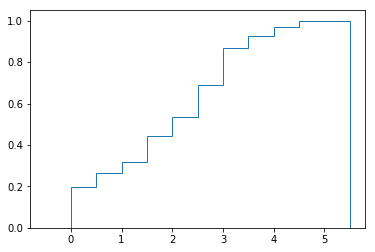

In [11]:
plt.hist(r_denoised, bins=np.arange(-0.5,6,0.5), cumulative=False, normed=False, histtype='bar')
plt.show()

plt.hist(r_denoised, bins=np.arange(-0.5,6,0.5), cumulative=True, normed=True, histtype='step')
plt.show()

31
44


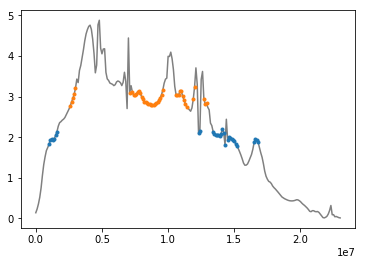

In [12]:
r1 = 2.0
r2 = 3.0
dr = 0.25
bool1 = np.abs(r_denoised - r1) <= dr
bool2 = np.abs(r_denoised - r2) <= dr
print(np.sum(bool1))
print(np.sum(bool2))
plt.plot(w_start_r, r_denoised, '-', c='.5')
plt.plot(w_start_r[bool1], r_denoised[bool1], '.')
plt.plot(w_start_r[bool2], r_denoised[bool2], '.')
plt.show()

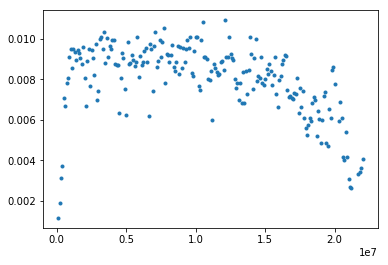

In [13]:
plt.plot(w_start_d, pi,'.')
plt.show()

In [15]:
r_sub = r_denoised[[w in w_start_d for w in w_start_r]]

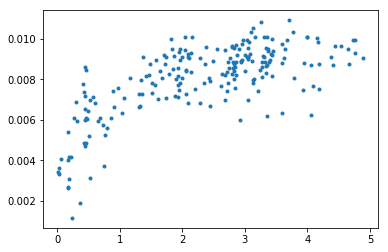

In [16]:
plt.plot(r_sub, pi, '.')
plt.show()

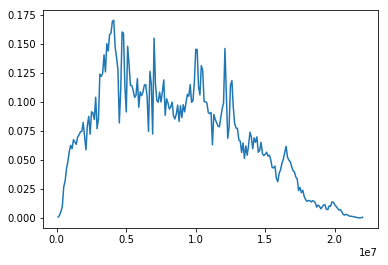

In [19]:
plt.plot(w_start_d, 3.6*r_sub*pi)
plt.show()

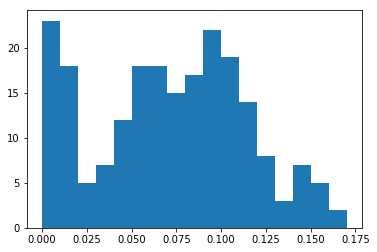

In [57]:
rho = 3.6*r_sub*pi
plt.hist(rho, bins=np.arange(0,0.175,.01))
plt.show()

40
60


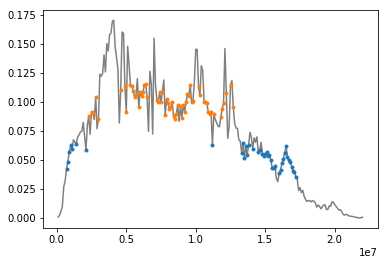

In [61]:
rho1 = 0.05
rho2 = 0.10
drho = 0.015
bool1 = np.abs(rho - rho1) <= drho
bool2 = np.abs(rho - rho2) <= drho
print(np.sum(bool1))
print(np.sum(bool2))
plt.plot(w_start_d, rho, '-', c='.5')
plt.plot(w_start_d[bool1], rho[bool1], '.')
plt.plot(w_start_d[bool2], rho[bool2], '.')
plt.show()

In [30]:
div100_fn = "../sandbox/old_diversity/Chr2L.all.N0.diversity.100.txt.gz"
data100 = np.loadtxt(div100_fn, skiprows=1)

In [83]:
w_start100, n_sites100, n_poly100, pi100 = data100[:,:4].T
MAF = data100[:,5:]

In [111]:
Lbar = 1.0 / np.mean(1.0/n_sites100)
print(Lbar)

51.3308535024


In [84]:
print(MAF.shape)
#Check that the number of polymorphic sites is consistent with the MAF
print(np.sum(n_poly100 - np.sum(MAF,axis=1)))

(196403, 76)
0.0


In [101]:
dw = 100000

w_d1 = w_start_d[bool1]
diff1 = w_d1[:,np.newaxis] - w_start100[np.newaxis,:]
b1 = np.any((diff1 >= 0) & (diff1 < dw), axis=0)
w1 = w_start100[b1]
pi1 = pi100[b1]

w_d2 = w_start_d[bool2]
diff2 = w_d2[:,np.newaxis] - w_start100[np.newaxis,:]
b2 = np.any((diff2 >= 0) & (diff2 < dw), axis=0)
w2 = w_start100[b2]
pi2 = pi100[b2]

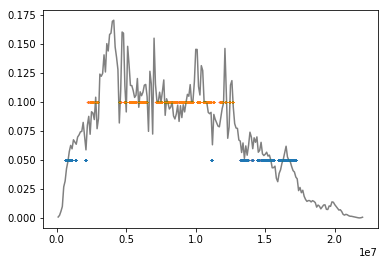

In [109]:
plt.plot(w_start_d, rho, '-', c='.5')
plt.plot(w1, rho1*np.ones_like(w1), '.', ms=0.05)
plt.plot(w2, rho2*np.ones_like(w2), '.',ms=0.05)
plt.show()

49.9721029163
49.1529681886


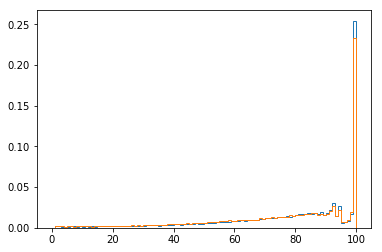

In [122]:
nsites1 = n_sites100[b1]
lbar1 = 1.0/np.mean(1.0/nsites1)
print(lbar1)
nsites2 = n_sites100[b2]
lbar2 = 1.0/np.mean(1.0/nsites2)
print(lbar2)
plt.hist(nsites1, bins=np.arange(101), histtype='step', normed=True)
plt.hist(nsites2, bins=np.arange(101), histtype='step', normed=True)
plt.show()

In [125]:
MAF1 = lbar1 * MAF[b1,:] / nsites1[:,np.newaxis]
MAF2 = lbar1 * MAF[b2,:] / nsites2[:,np.newaxis]

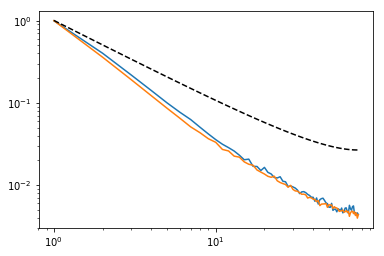

In [133]:
x = np.arange(1, MAF.shape[1]+1)
sfs_neut = 1.0/x + (1.0/(150-x))
avgSFS1 = np.mean(MAF1,axis=0)
avgSFS1 /= avgSFS1[0]
avgSFS2 = np.mean(MAF2,axis=0)
avgSFS2 /= avgSFS2[0]
plt.loglog(x, avgSFS1)
plt.loglog(x, avgSFS2)
plt.loglog(x, sfs_neut, '--k')
plt.show()

In [139]:
avgSFS1_sq = avgSFS1[None,:]*avgSFS1[:,None]
covSFS1 = (np.mean(MAF1[:,None,:]*MAF1[:,:,None], axis=0) - avgSFS1_sq) / avgSFS1_sq
np.fill_diagonal(covSFS1,0)

In [140]:
avgSFS2_sq = avgSFS2[None,:]*avgSFS2[:,None]
covSFS2 = (np.mean(MAF2[:,None,:]*MAF2[:,:,None], axis=0) - avgSFS2_sq) / avgSFS2_sq
np.fill_diagonal(covSFS2,0)

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


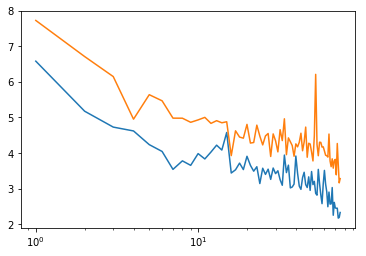

In [153]:
diag1 = np.array([np.mean(np.diagonal(covSFS1,offset=i)) for i in x])
plt.semilogx(x, diag1,'-')
diag2 = np.array([np.mean(np.diagonal(covSFS2,offset=i)) for i in x])
plt.semilogx(x, diag2,'-')
plt.show()

# Need to make 2x longer windows for the 1/2 recombination rate

In [152]:
A = np.arange(10)
B = np.array([0,4,8])
print(A[B])

[0 4 8]


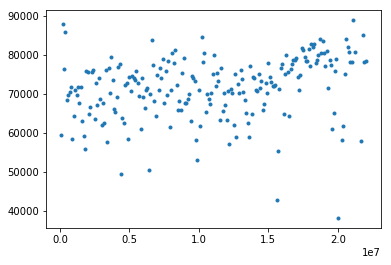

In [11]:
plt.plot(w_start_d, n_sites, '.')
plt.show()

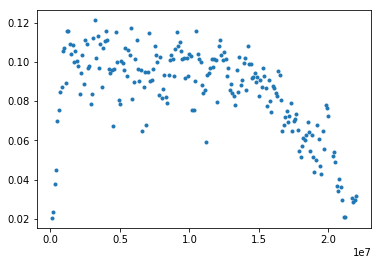

In [12]:
plt.plot(w_start_d, n_poly/n_sites, '.')
plt.show()

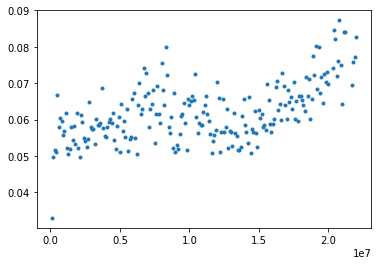

In [13]:
plt.plot(w_start_d, avg_maf, '.')
plt.show()

In [14]:
R_sub = [r[[w in w_start_d for w in w_start_r]] for r in R]

In [ ]:
pearson_R = []
spearman_R = []
for t, r_sm in zip(T, R_sub):
    pR = stats.pearsonr(r_sm, pi)[0]
    sR = stats.spearmanr(r_sm, pi)[0]
    print("Threshold: {}".format(t))
    print("Pearson R:  {:.3f}".format(pR))
    print("Spearman R: {:.3f}".format(sR))
    pearson_R.append(pR)
    spearman_R.append(sR)
    
    lin_reg = stats.linregress(r_sm, pi)
    print("Slope: {:.5f}".format(lin_reg.slope))

    plt.plot(r_sm, pi, '.')
    plt.xlim([-1,11])
    plt.show()

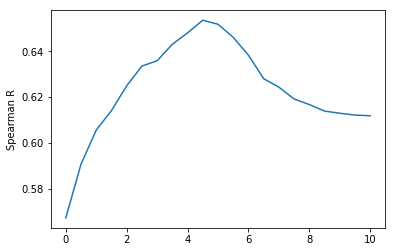

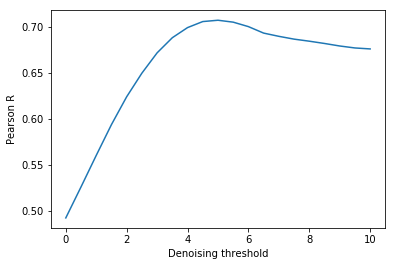

In [16]:
plt.plot(T, spearman_R)
plt.ylabel('Spearman R')
plt.show()
plt.plot(T, pearson_R)
plt.ylabel('Pearson R')
plt.xlabel('Denoising threshold')
plt.show()

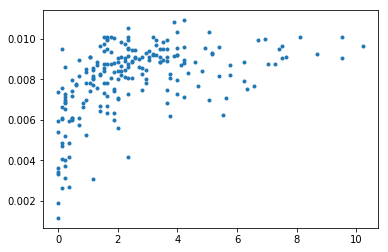

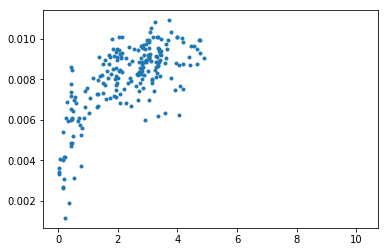

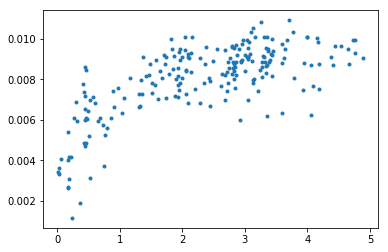

In [17]:
plt.plot(R_sub[0], pi, '.')
xlim = plt.gca().get_xlim()
plt.show()
plt.plot(R_sub[9], pi, '.')
plt.xlim(xlim)
plt.show()
plt.plot(R_sub[9], pi, '.')
plt.show()

In [18]:
chroms = ['2L','2R','3L','3R']
POS = []
R_raw = []
R_sm  = []
PI    = []
for c in chroms:
    w_start_r, recomb = np.loadtxt(recomb_dir + 'Comeron_100kb_chr{}.txt'.format(c), unpack=True)
    div_fn = "../sandbox/Chr{}.all.N0.diversity.100000.txt.gz".format(c)
    pos, pi = np.loadtxt(div_fn, skiprows=1, usecols=[0,3], unpack=True)
    
    min_r = min(recomb[recomb>0])
    recomb_norm = np.round(recomb / min_r)
    r_denoised = denoise(recomb_norm, t=4.5, wavelet=wavelet)*min_r
    
    R_raw.append(recomb[[w in pos for w in w_start_r]])
    R_sm.append(r_denoised[[w in pos for w in w_start_r]])
    POS.append(pos)
    PI.append(pi)

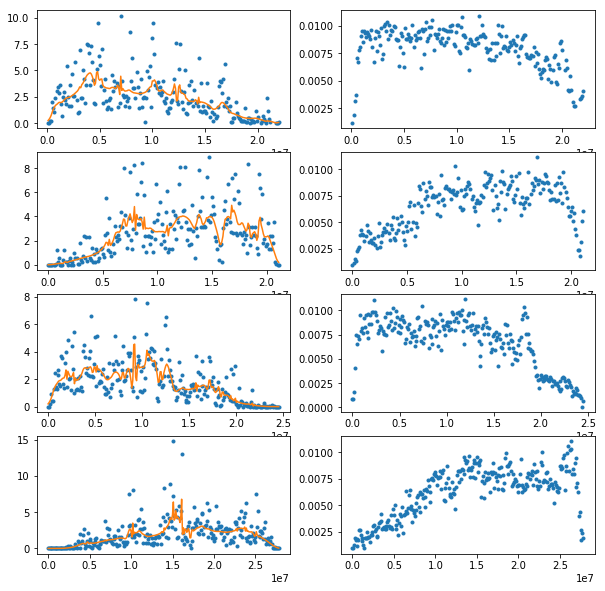

In [19]:
plt.figure(figsize=(10,10))
for i in range(4):
    ax = plt.subplot(4,2, 2*i + 1)
    ax.plot(POS[i], R_raw[i], '.')
    ax.plot(POS[i], R_sm[i], '-')
    
    ax = plt.subplot(4,2, 2*i + 2)
    ax.plot(POS[i], PI[i], '.')

plt.show()

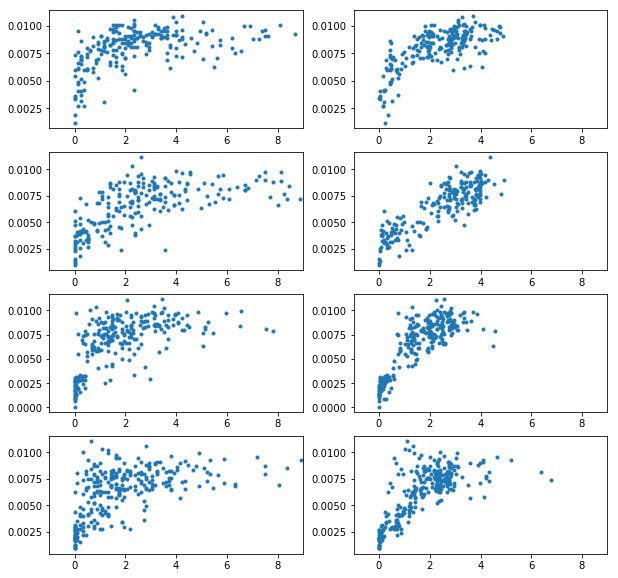

In [20]:
plt.figure(figsize=(10,10))
for i in range(4):
    ax = plt.subplot(4,2, 2*i + 1)
    ax.plot(R_raw[i], PI[i], '.')
    ax.set_xlim([-1,9])
    
    ax = plt.subplot(4,2, 2*i + 2)
    ax.plot(R_sm[i], PI[i], '.')
    ax.set_xlim([-1,9])

plt.show()

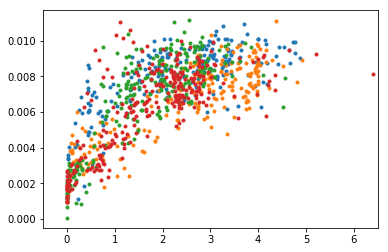

In [21]:
for i in range(4):
    plt.plot(R_sm[i], PI[i], '.')
    plt.xlim([-0.5,6.5])
plt.show()

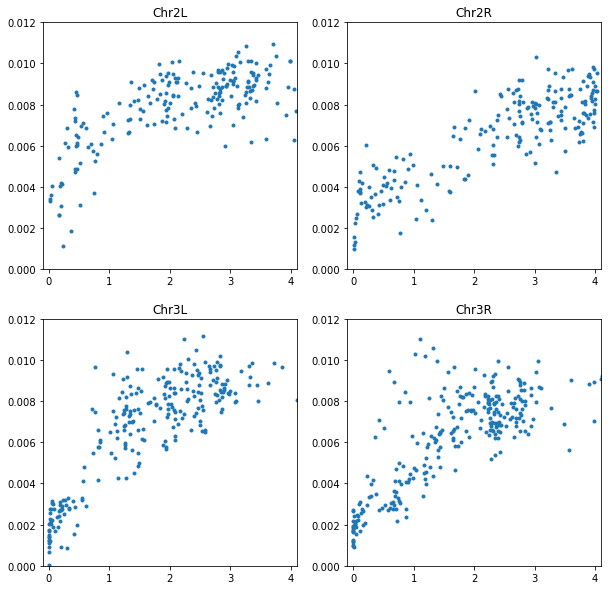

In [22]:
plt.figure(figsize=(10,10))
for i in range(4):    
    ax = plt.subplot(2,2, i+1)
    ax.plot(R_sm[i], PI[i], '.')
    ax.set_title('Chr{}'.format(chroms[i]))
    ax.set_xlim([-0.1,4.1])
    ax.set_ylim([0,0.012])
plt.show()

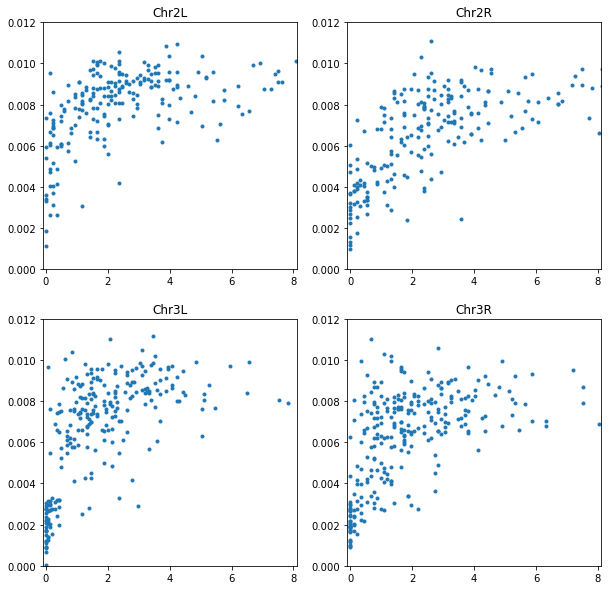

In [23]:
plt.figure(figsize=(10,10))
for i in range(4):    
    ax = plt.subplot(2,2, i+1)
    ax.plot(R_raw[i], PI[i], '.')
    ax.set_title('Chr{}'.format(chroms[i]))
    ax.set_xlim([-0.1,8.1])
    ax.set_ylim([0,0.012])
plt.show()

# Simulations

In [24]:
dx = 0.01
sig_y = 0.1
#f_y = 5
f_y = 20
a_y = 0.1

y0 = 0.5
sig_z = 0.05

X = np.arange(0,1+dx,dx)
Y = 4*X*(1-X) + a_y*np.sin(2*np.pi*X * f_y)
Z = 1-np.exp(-Y/y0)
Y_obs = np.random.normal(Y, scale=sig_y)
Z_obs = np.random.normal(Z, scale=sig_z)

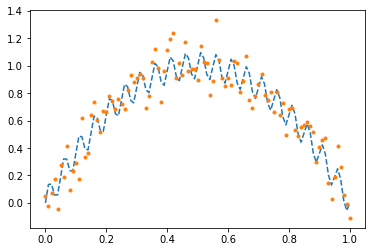

In [25]:
plt.plot(X,Y,'--')
plt.plot(X,Y_obs,'.')
plt.show()

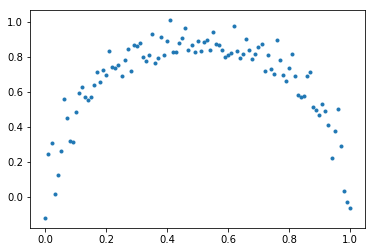

In [26]:
plt.plot(X,Z_obs,'.')
plt.show()

threshold = 0.0


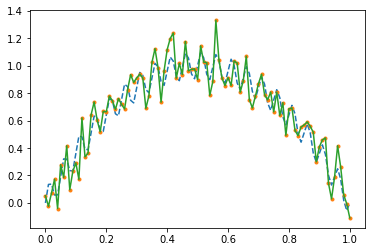

threshold = 0.05


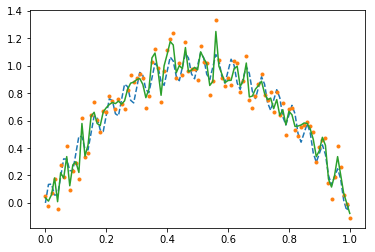

threshold = 0.1


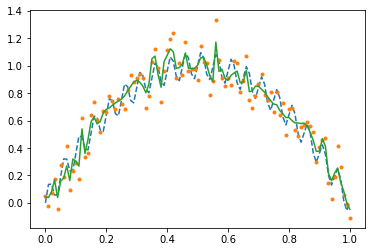

threshold = 0.15000000000000002


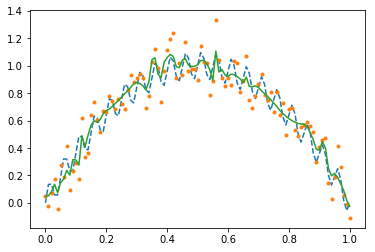

threshold = 0.2


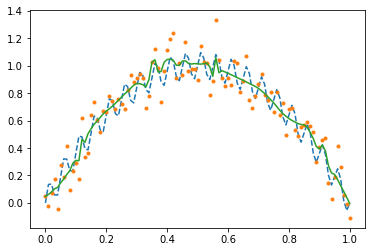

threshold = 0.25


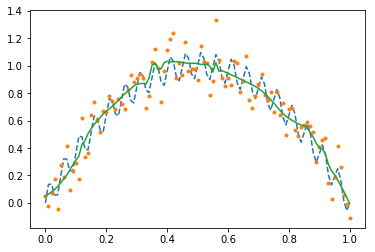

threshold = 0.30000000000000004


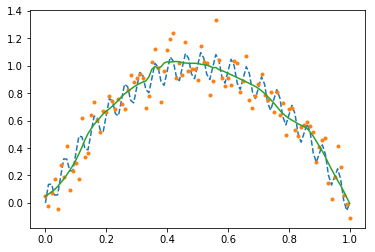

threshold = 0.35000000000000003


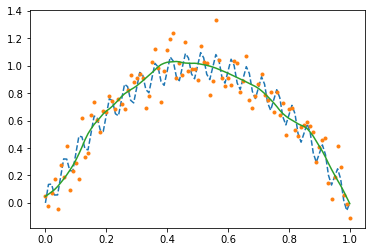

threshold = 0.4


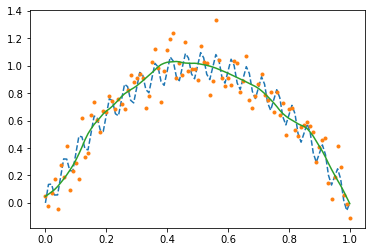

threshold = 0.45


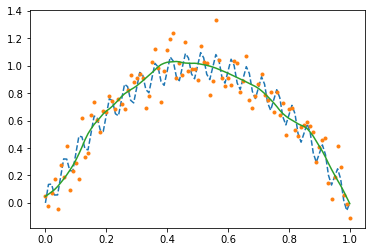

threshold = 0.5


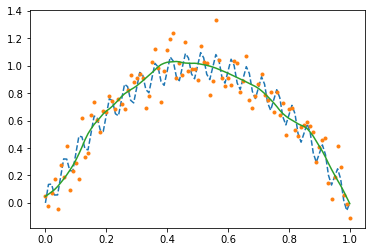

threshold = 0.55


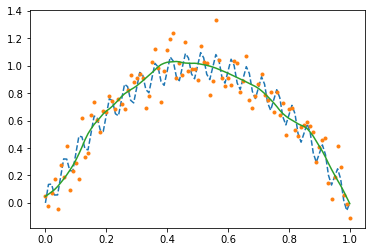

threshold = 0.6000000000000001


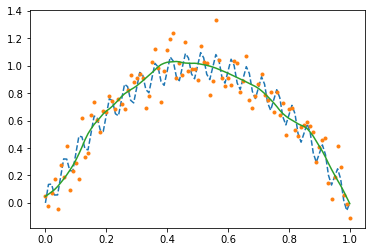

threshold = 0.65


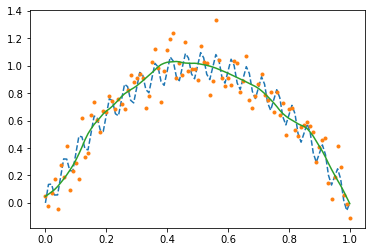

threshold = 0.7000000000000001


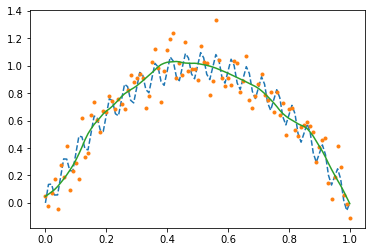

threshold = 0.75


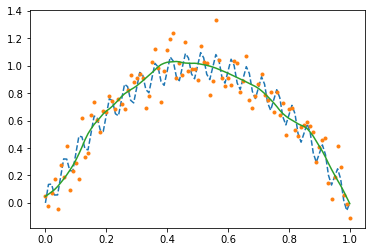

threshold = 0.8


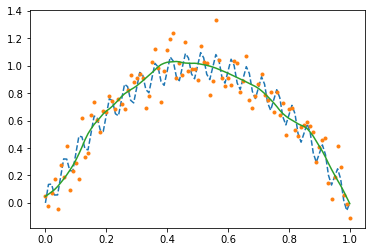

threshold = 0.8500000000000001


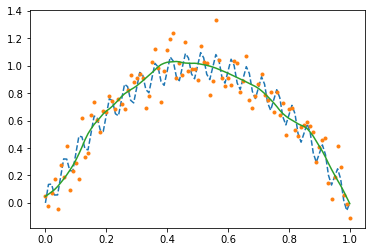

threshold = 0.9


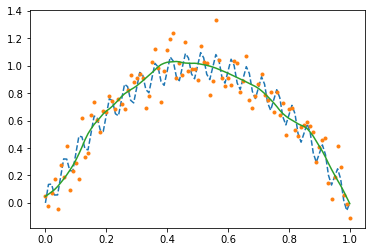

threshold = 0.9500000000000001


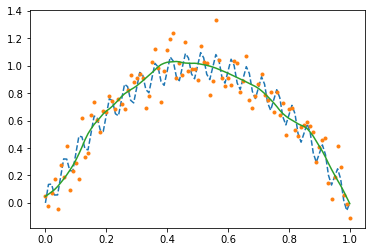

threshold = 1.0


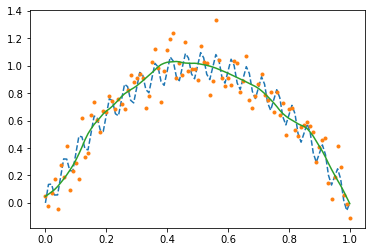

In [27]:
wavelet = 'db4'
T = sig_y * np.arange(0, 10.5, .5)
Y_hat = []
for t in T:
    print("threshold = {}".format(t))
    y_denoised = denoise(Y_obs, t=t, wavelet=wavelet, anscombe=False)
    Y_hat.append(y_denoised)
    plt.plot(X, Y,'--')
    plt.plot(X, Y_obs, '.')
    plt.plot(X, y_denoised, '-')
    plt.show()

Threshold: 0.0
Pearson R:  0.903
Spearman R: 0.901
Slope: 0.67604


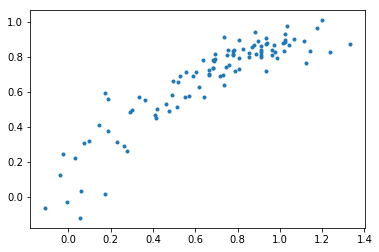

Threshold: 0.05
Pearson R:  0.917
Spearman R: 0.907
Slope: 0.70791


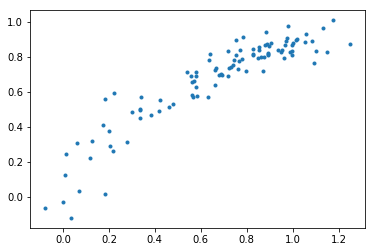

Threshold: 0.1
Pearson R:  0.919
Spearman R: 0.900
Slope: 0.72312


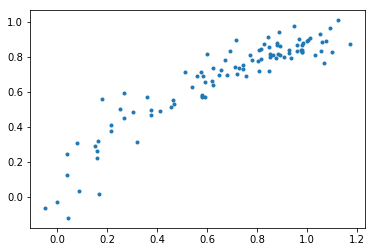

Threshold: 0.15000000000000002
Pearson R:  0.919
Spearman R: 0.898
Slope: 0.73007


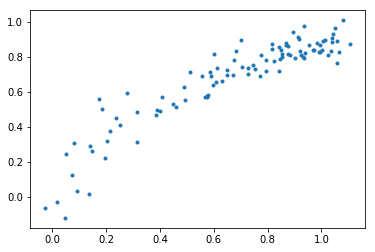

Threshold: 0.2
Pearson R:  0.919
Spearman R: 0.896
Slope: 0.73385


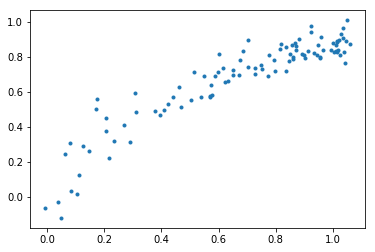

Threshold: 0.25
Pearson R:  0.919
Spearman R: 0.892
Slope: 0.73523


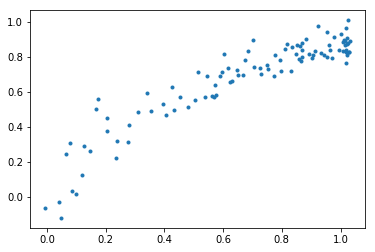

Threshold: 0.30000000000000004
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73567


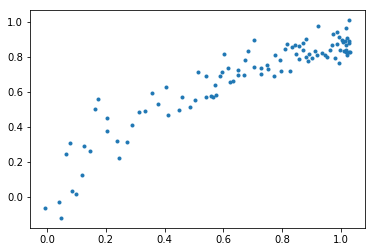

Threshold: 0.35000000000000003
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


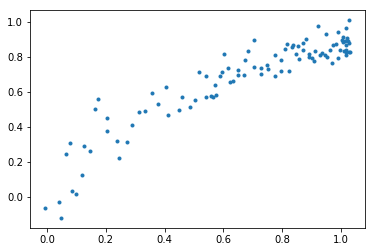

Threshold: 0.4
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


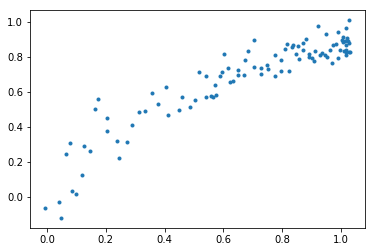

Threshold: 0.45
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


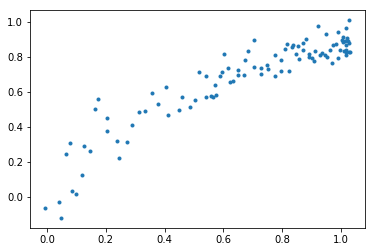

Threshold: 0.5
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


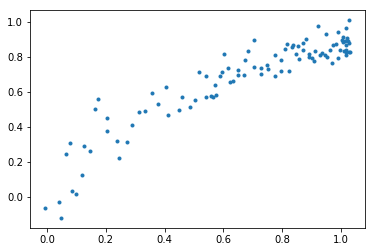

Threshold: 0.55
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


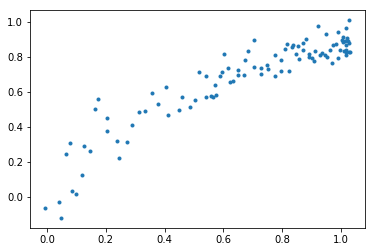

Threshold: 0.6000000000000001
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


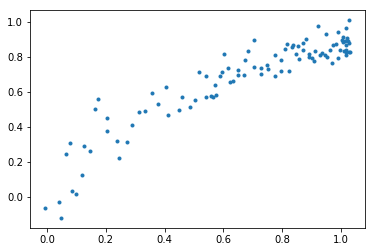

Threshold: 0.65
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


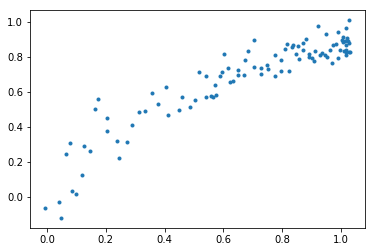

Threshold: 0.7000000000000001
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


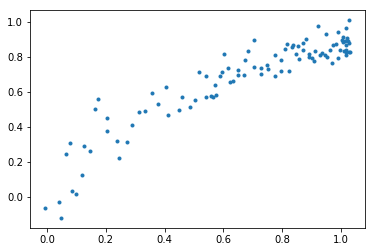

Threshold: 0.75
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


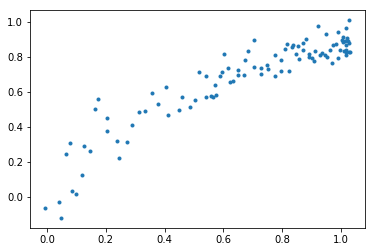

Threshold: 0.8
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


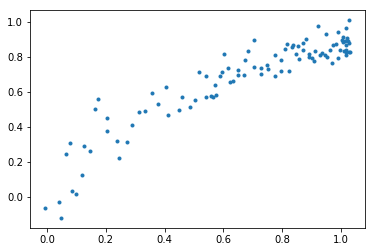

Threshold: 0.8500000000000001
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


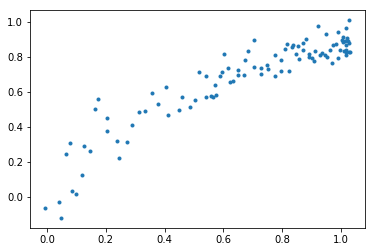

Threshold: 0.9
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


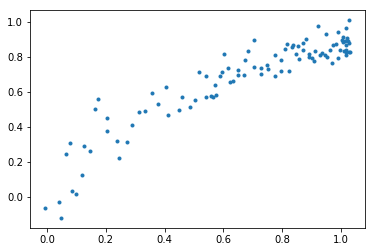

Threshold: 0.9500000000000001
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


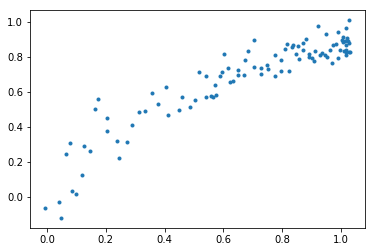

Threshold: 1.0
Pearson R:  0.919
Spearman R: 0.893
Slope: 0.73566


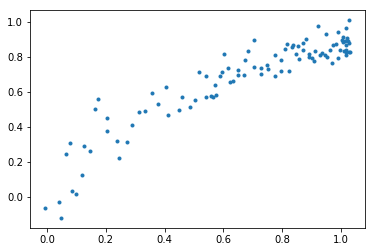

In [28]:
pearson_R = []
spearman_R = []
for t, y_hat in zip(T, Y_hat):
    pR = stats.pearsonr(y_hat, Z_obs)[0]
    sR = stats.spearmanr(y_hat, Z_obs)[0]
    print("Threshold: {}".format(t))
    print("Pearson R:  {:.3f}".format(pR))
    print("Spearman R: {:.3f}".format(sR))
    pearson_R.append(pR)
    spearman_R.append(sR)
    
    lin_reg = stats.linregress(y_hat, Z_obs)
    print("Slope: {:.5f}".format(lin_reg.slope))

    plt.plot(y_hat, Z_obs, '.')
    #plt.xlim([-1,11])
    plt.show()

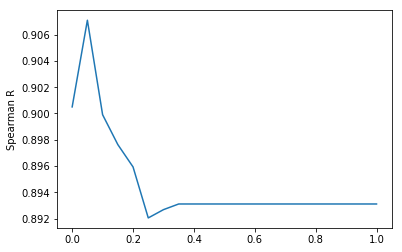

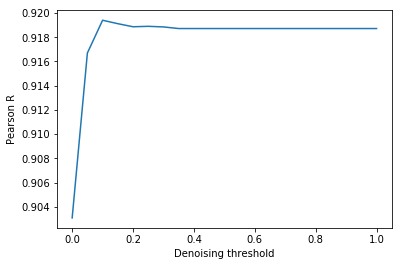

In [29]:
plt.plot(T, spearman_R)
plt.ylabel('Spearman R')
plt.show()
plt.plot(T, pearson_R)
plt.ylabel('Pearson R')
plt.xlabel('Denoising threshold')
plt.show()

2 0.900500873617
3 0.907513104252
4 0.9070937682
5 0.907839254514
6 0.900500873617
7 0.910029120559
8 0.908235294118
9 0.905789167152
10 0.91006406523


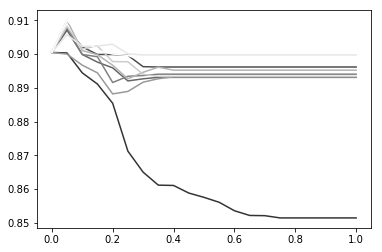

In [30]:
T = sig_y * np.arange(0, 10.5, .5)
#Y_hat = []
for i in range(2,11):
    sR = []
    for t in T:
        w = "db{}".format(i)
        y_denoised = denoise(Y_obs, t=t, wavelet=w, anscombe=False)
        sR.append(stats.spearmanr(y_denoised, Z_obs)[0])
    plt.plot(T,sR,color=str(i/10))
    print(i,max(sR))
plt.show()



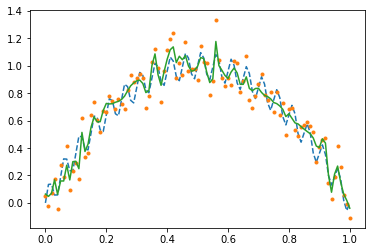

In [31]:
y_denoised = denoise(Y_obs, t=T[2], wavelet='db5', anscombe=False)
plt.plot(X,Y,'--')
plt.plot(X,Y_obs,'.')
plt.plot(X,y_denoised)
plt.show()